In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa

# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_multi import Server
from client_multi import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list)
                 for clientID, client_name in enumerate(active_clients_list)}

temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()
    client.close()  # Đóng Dask Client sau khi hoàn tất

2025-06-24 13:56:22.925765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 13:56:22.983398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750748183.007536   69410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750748183.013739   69410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750748183.041127   69410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:43935' processes=2 threads=4, memory=7.45 GiB>
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC        

I0000 00:00:1750748189.636157   69410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/5
Epoch 1/5
Epoch 1/5


I0000 00:00:1750748193.543772   69509 service.cc:152] XLA service 0x7f8674002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750748193.543827   69509 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750748193.563544   69509 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750748193.722088   69514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-24 13:56:37.521604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  77/3739 ━━━━━━━━━━━━━━━━━━━━ 2:27 40ms/step - accuracy: 0.5082 - loss: 1.3852

2025-06-24 13:56:43.803144: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4520/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9025 - loss: 0.2755

2025-06-24 13:57:10.641826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:10.692660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:10.768397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



4844/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9047 - loss: 0.2687

2025-06-24 13:57:12.441933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 13:57:12.524471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:12.563453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4995/5338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9056 - loss: 0.2657

2025-06-24 13:57:13.415895: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:13.602029: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



5035/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9059 - loss: 0.2649

2025-06-24 13:57:13.627752: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5198/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9068 - loss: 0.2619

2025-06-24 13:57:14.504138: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5237/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9071 - loss: 0.2612

2025-06-24 13:57:14.724274: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:14.726177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5333/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9076 - loss: 0.2595

2025-06-24 13:57:15.584652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:15.677316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 13:57:15.861732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:17.049974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:17.089123: I external

3739/3739 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.9013 - loss: 0.2799 - val_accuracy: 0.9510 - val_loss: 0.1222
Epoch 2/5
 193/3739 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9480 - loss: 0.1321

2025-06-24 13:57:48.460156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:48.518843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:48.590488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



 290/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9479 - loss: 0.1324

2025-06-24 13:57:49.071879: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 325/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9478 - loss: 0.1325

2025-06-24 13:57:49.362779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



 392/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9478 - loss: 0.1325

2025-06-24 13:57:49.833437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



 888/3739 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9479 - loss: 0.1323

2025-06-24 13:57:51.672509: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:51.715922: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 292 bytes spill stores, 292 bytes spill loads



 937/3739 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9479 - loss: 0.1323

2025-06-24 13:57:51.905801: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



 970/3739 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9479 - loss: 0.1322

2025-06-24 13:57:52.351651: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1269/3739 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9480 - loss: 0.1321

2025-06-24 13:57:53.585182: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



1336/3739 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9480 - loss: 0.1320

2025-06-24 13:57:53.976792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:57:54.072045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



4262/4262 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.9111 - loss: 0.2562 - val_accuracy: 0.9512 - val_loss: 0.1192
Epoch 2/5
2286/3739 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9482 - loss: 0.1314

2025-06-24 13:57:58.197934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:57:58.203079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 13:57:58.377941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



2344/3739 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9482 - loss: 0.1314

2025-06-24 13:57:58.787819: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1309/4262 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9491 - loss: 0.1288

2025-06-24 13:58:00.571805: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:58:00.762897: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



1353/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9492 - loss: 0.1287

2025-06-24 13:58:00.439023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 13:58:00.566463: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 13:58:00.714575: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 13:58:00.819396: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1632/4262 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9493 - loss: 0.1285

2025-06-24 13:58:02.077117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:58:02.128438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 13:58:02.154521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



5338/5338 ━━━━━━━━━━━━━━━━━━━━ 94s 16ms/step - accuracy: 0.9076 - loss: 0.2594 - val_accuracy: 0.9522 - val_loss: 0.1181
Epoch 2/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9485 - loss: 0.1305 - val_accuracy: 0.9532 - val_loss: 0.1150
2530/4262 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9495 - loss: 0.1277Epoch 3/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9499 - loss: 0.1265 - val_accuracy: 0.9551 - val_loss: 0.1101
Epoch 3/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9514 - loss: 0.1216 - val_accuracy: 0.9555 - val_loss: 0.1103
4280/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9494 - loss: 0.1274Epoch 4/5
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9497 - loss: 0.1267 - val_accuracy: 0.9548 - val_loss: 0.1097
Epoch 3/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9528 - loss: 0.1180 - val_accuracy: 0.9566 - val_loss: 0.1065
Epoch 4/5
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9529 - lo

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1029/5338 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9544 - loss: 0.1127client_1 End Produce Weights
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9550 - loss: 0.1113 - val_accuracy: 0.9582 - val_loss: 0.1025
4660/5338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9542 - loss: 0.1133Done model fit

4671/5338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9542 - loss: 0.1133client_2 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9542 - loss: 0.1132 - val_accuracy: 0.9568 - val_loss: 0.1050
Epoch 5/5
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9551 - loss: 0.1112 - val_accuracy: 0.9579 - val_loss: 0.1021
Done model fit

client_0 End Produce Weights
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-13h-56p/client_0_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-13h-56p/client_1_log/global_model_iter_1.keras
Đã lưu global model cho iteration 1 tại mult

2025-06-24 13:59:44.127556: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 13:59:44.165826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 13:59:44.222428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



 15/702 ━━━━━━━━━━━━━━━━━━━━ 2:01 177ms/step - accuracy: 0.9586 - loss: 0.1095

2025-06-24 13:59:44.930424: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  11/1001 ━━━━━━━━━━━━━━━━━━━━ 4:53 296ms/step - accuracy: 0.9621 - loss: 0.0997

2025-06-24 13:59:48.305308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 8 bytes spill stores, 8 bytes spill loads

2025-06-24 13:59:48.347333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 52 bytes spill stores, 52 bytes spill loads



186/800 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9573 - loss: 0.1059

2025-06-24 13:59:48.586281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 292 bytes spill stores, 292 bytes spill loads



227/800 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9572 - loss: 0.1058

2025-06-24 13:59:48.825296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 724 bytes spill stores, 788 bytes spill loads



307/800 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9572 - loss: 0.1055

2025-06-24 13:59:49.256191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 52 bytes spill stores, 52 bytes spill loads

2025-06-24 13:59:49.399430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 292 bytes spill stores, 292 bytes spill loads



356/800 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9572 - loss: 0.1054

2025-06-24 13:59:49.766327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 8 bytes spill stores, 8 bytes spill loads



371/800 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9572 - loss: 0.1054

2025-06-24 13:59:50.017072: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 724 bytes spill stores, 788 bytes spill loads

2025-06-24 13:59:50.157673: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 13:59:50.172366: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, Cores: 20, GPU clock: 2.055 GHz, Memory bandwidth: 192 GB/s, L2 cache: 24 MB', hlo='{
  tmp_0 = f32[704,128]{1,0} parameter(1)
  tmp_1 = f16[704,128]{1,0} convert(f32[704,128]{1,0} tmp_0)
  tmp_2 = f16[512,1,11,64]{3,2,1,0} parameter(0)
  tmp_3 = f16[512,704]{1,0} bitcast(f16[512,1,11,64]{3,2,1,0} tmp_2)
  tmp_4 = f16[128,512]{0,1} dot(f16[704,128]{1

800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9572 - loss: 0.1049
702/702 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9564 - loss: 0.1070
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7820 - loss: 0.9159
 587/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9582 - loss: 0.1023 Performance Metrics for client_2 on iteration 1 
------------------------------------------- 
local accuracy: 0.9575093388557434 
local loss: 0.10406722128391266 
global accuracy: 0.7819238901138306 
global_loss: 0.9167085886001587 
local compute time: 0:02:48.925216 
Simulated time to receive global weights: 0:03:07.273985 
 

702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8301 - loss: 0.7109
Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.9564863443374634 
local loss: 0.10584966093301773 
global accuracy: 0.8304145336151123 
global_loss: 0.7121373414993286 
local compute time: 0:02:35.170921 
Simulat

In [5]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Giả định các biến global như tempdirs, active_clients_list, test_gens, stepsTest_Clients đã được định nghĩa
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

# Tự động xác định số iteration cho từng client
model_names_template = [f"global_model_iter_{i+1}.keras" for i in range(8)]  # Danh sách tiềm năng
actual_iterations = {}
for i, client_dir in enumerate(tempdirs):
    existing_models = [m for m in model_names_template if os.path.exists(client_dir + m)]
    if existing_models:
        current_max = max([int(m.split('_')[-1].split('.')[0]) for m in existing_models])
        actual_iterations[f'client_{i}'] = current_max
    else:
        actual_iterations[f'client_{i}'] = 8  # Mặc định 8 nếu không tìm thấy tệp
model_names = {f'client_{i}': [f"global_model_iter_{j}.keras" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
Iterations = {f'client_{i}': [f"Iteration {j}" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
print(f"Detected iterations: {actual_iterations}")

# Load models
models = {}
for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i] + model_name) for model_name in model_names[client_name]]
print(models['client_0'])

Detected iterations: {'client_0': 5, 'client_1': 5, 'client_2': 5}


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 34 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-06-24 14:18:26.138384: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


517399
<Sequential name=sequential, built=True>


2025-06-24 14:18:26.495236: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-06-24 14:18:26.727374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 8 bytes spill stores, 8 bytes spill loads

2025-06-24 14:18:26.823268: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 14:18:27.003348: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 292 bytes spill stores, 292 bytes spill loads

2025-06-24 14:18:27.123471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation

16134/16169 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 14:18:46.411651: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 14:18:46.648379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 14:18:46.672329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 14:18:46.734281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 272 bytes spill stores, 272 bytes spill loads



16169/16169 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Sequential name=sequential, built=True>
16169/16169 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
<Sequential name=sequential, built=True>
16169/16169 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
<Sequential name=sequential, built=True>
16169/16169 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
<Sequential name=sequential, built=True>
16169/16169 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
Precision Score:  [0.5142199065988791, 0.8996270799244608, 0.899817700493848, 0.8998579728135923, 0.9033847932894027]
Recall Score:  [0.4130425007745292, 0.8365159760298685, 0.843614218993301, 0.8518715153174388, 0.8521683030455842]
F1 Score:  [0.38074244030388954, 0.8586364843688937, 0.8641184296096439, 0.8701135545651015, 0.871414076367253]


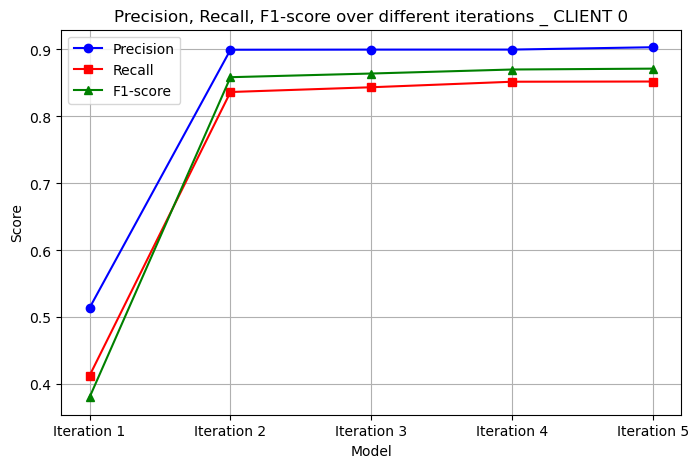

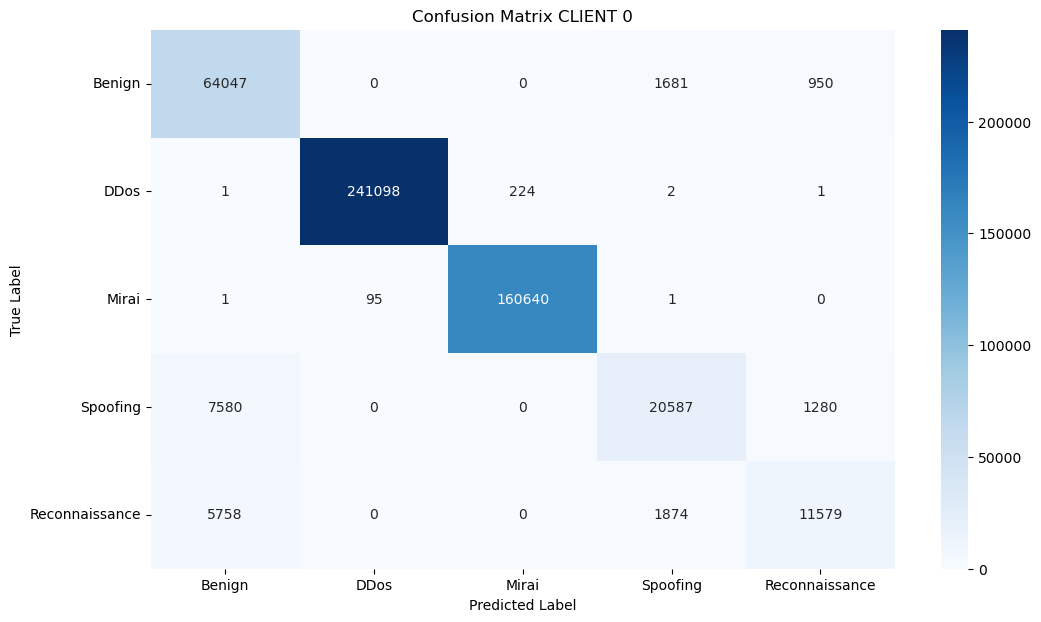

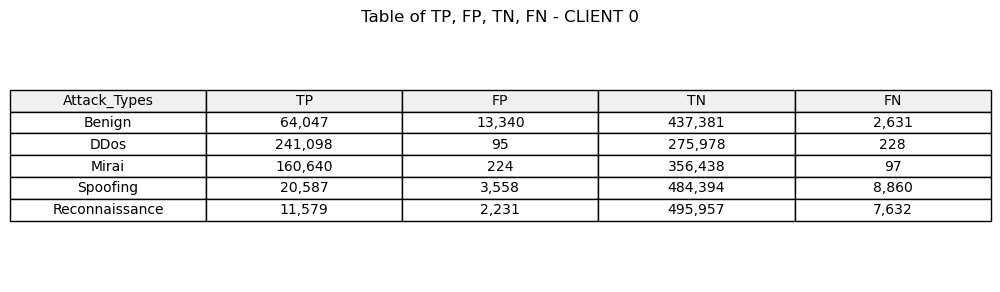

/tmp/ipykernel_69410/3019819921.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


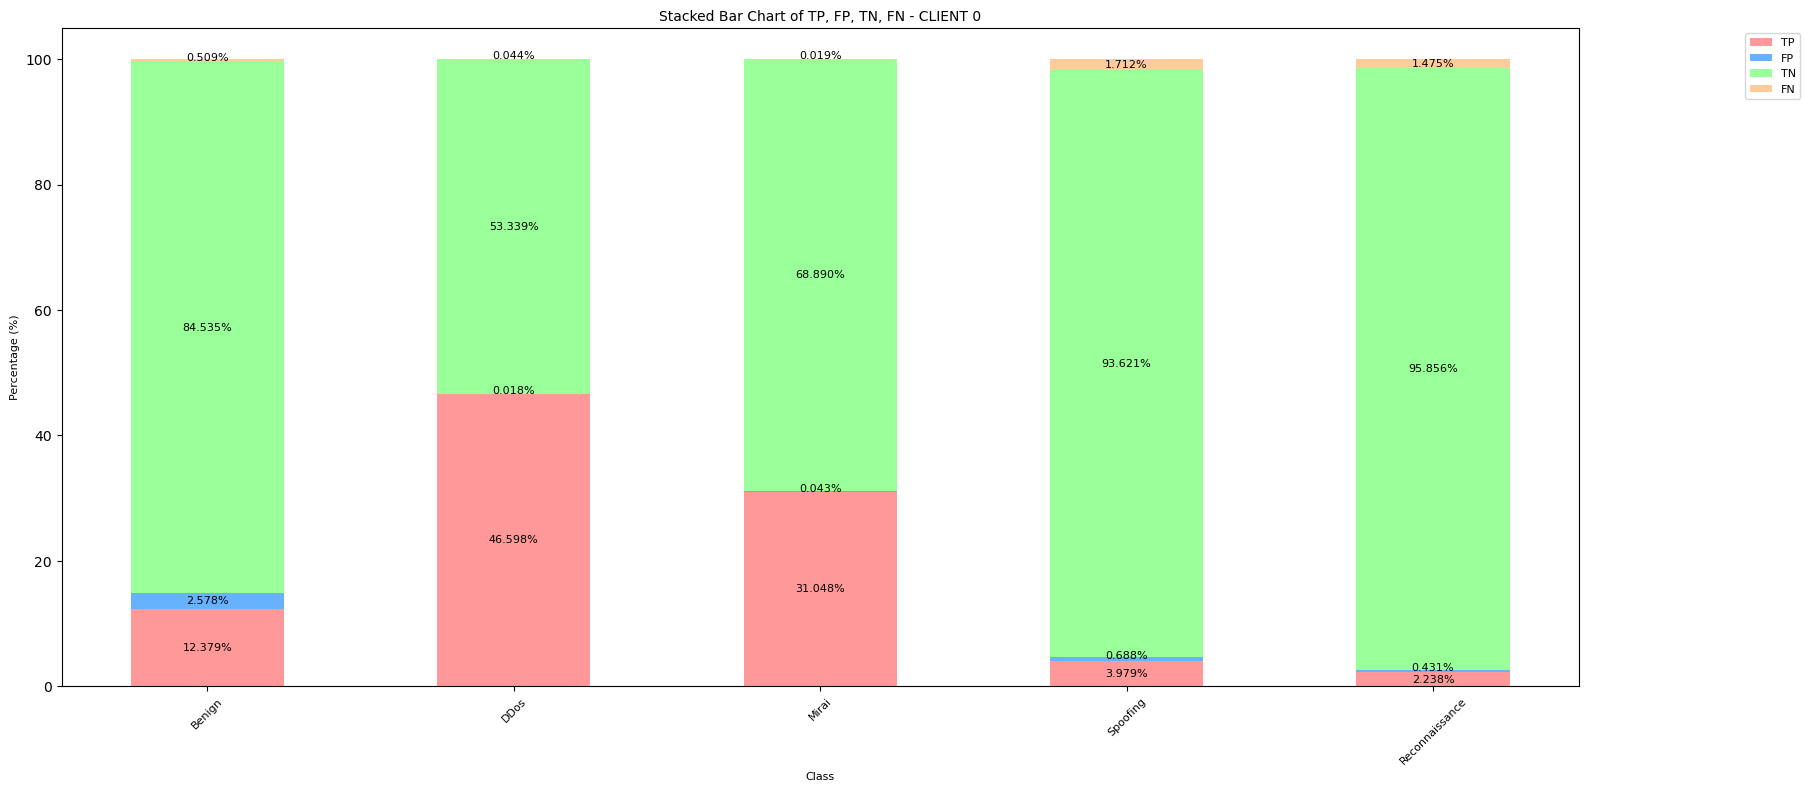

In [6]:
# Client 0
precisions = []
recalls = []
f1s = []

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(actual_iterations['client_0']):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)

# Vẽ biểu đồ Precision, Recall, F1-score
plt.figure(figsize=(8, 5))
plt.plot(Iterations['client_0'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations['client_0'], recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations['client_0'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.grid(True)
plt.savefig(tempdirs[0] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()

attack_types = ['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")
plt.savefig(tempdirs[0] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính và vẽ TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 0", fontsize=12, pad=5)
plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(18, 8))
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            y_pos = bottom[i] + height / 2
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,
                    fontsize=8, color="black")
    bottom += df_metrics[metric]

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 0", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))
plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

2025-06-24 14:20:42.248798: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


363543
<Sequential name=sequential_1, built=True>
11361/11361 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11361/11361 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11361/11361 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11361/11361 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11361/11361 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Precision Score Client 1:  [0.8145472912214942, 0.8911316537662438, 0.8942742771988315, 0.9001042674462314, 0.893794952024141]
Recall Score Client 1:  [0.504124375800312, 0.8382666458076254, 0.8461319740426422, 0.8397935373361578, 0.8544253480060666]
F1 Score Client 1:  [0.48940061556597536, 0.8568658189840299, 0.863992727505939, 0.8612225097068589, 0.8697014645041372]


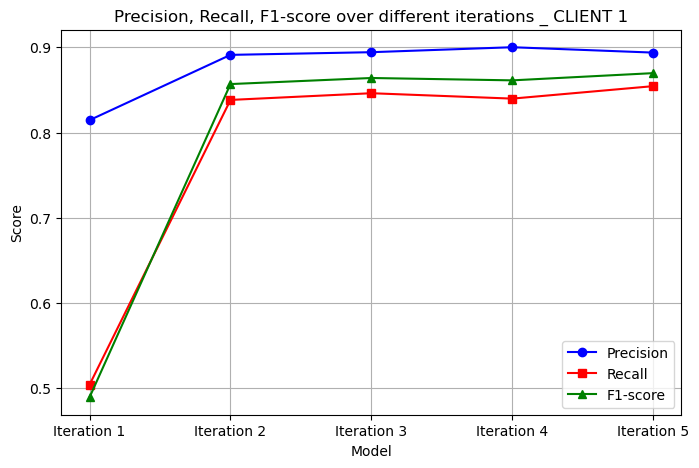

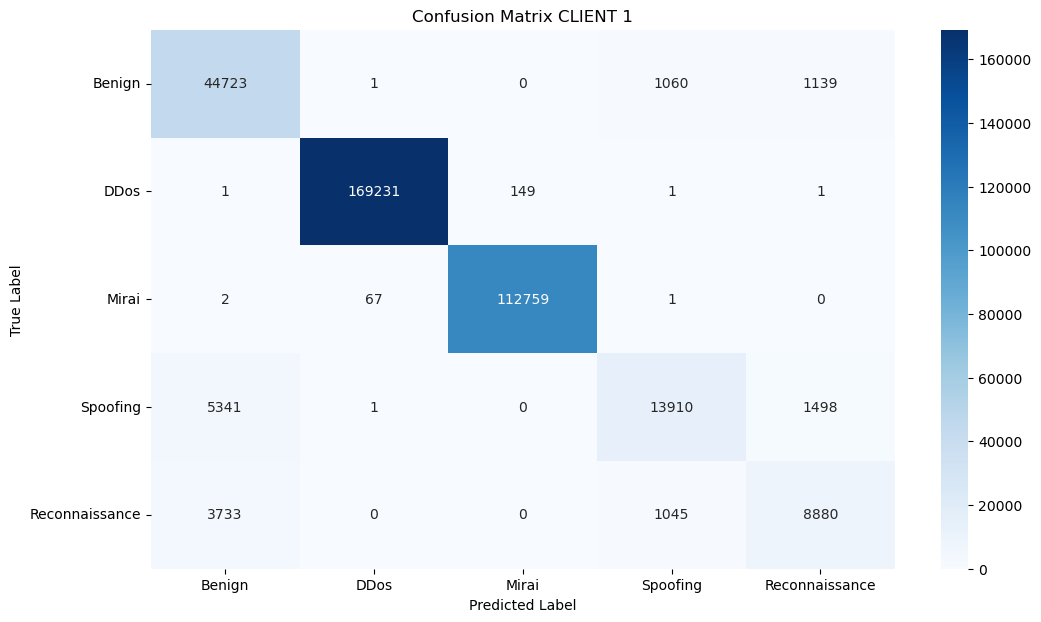

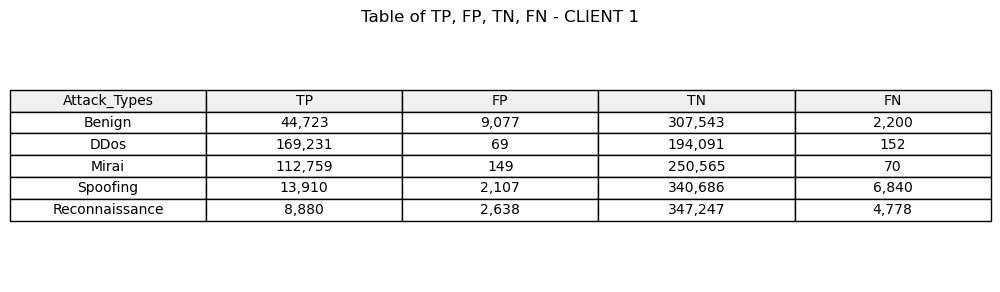

/tmp/ipykernel_69410/3927783715.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


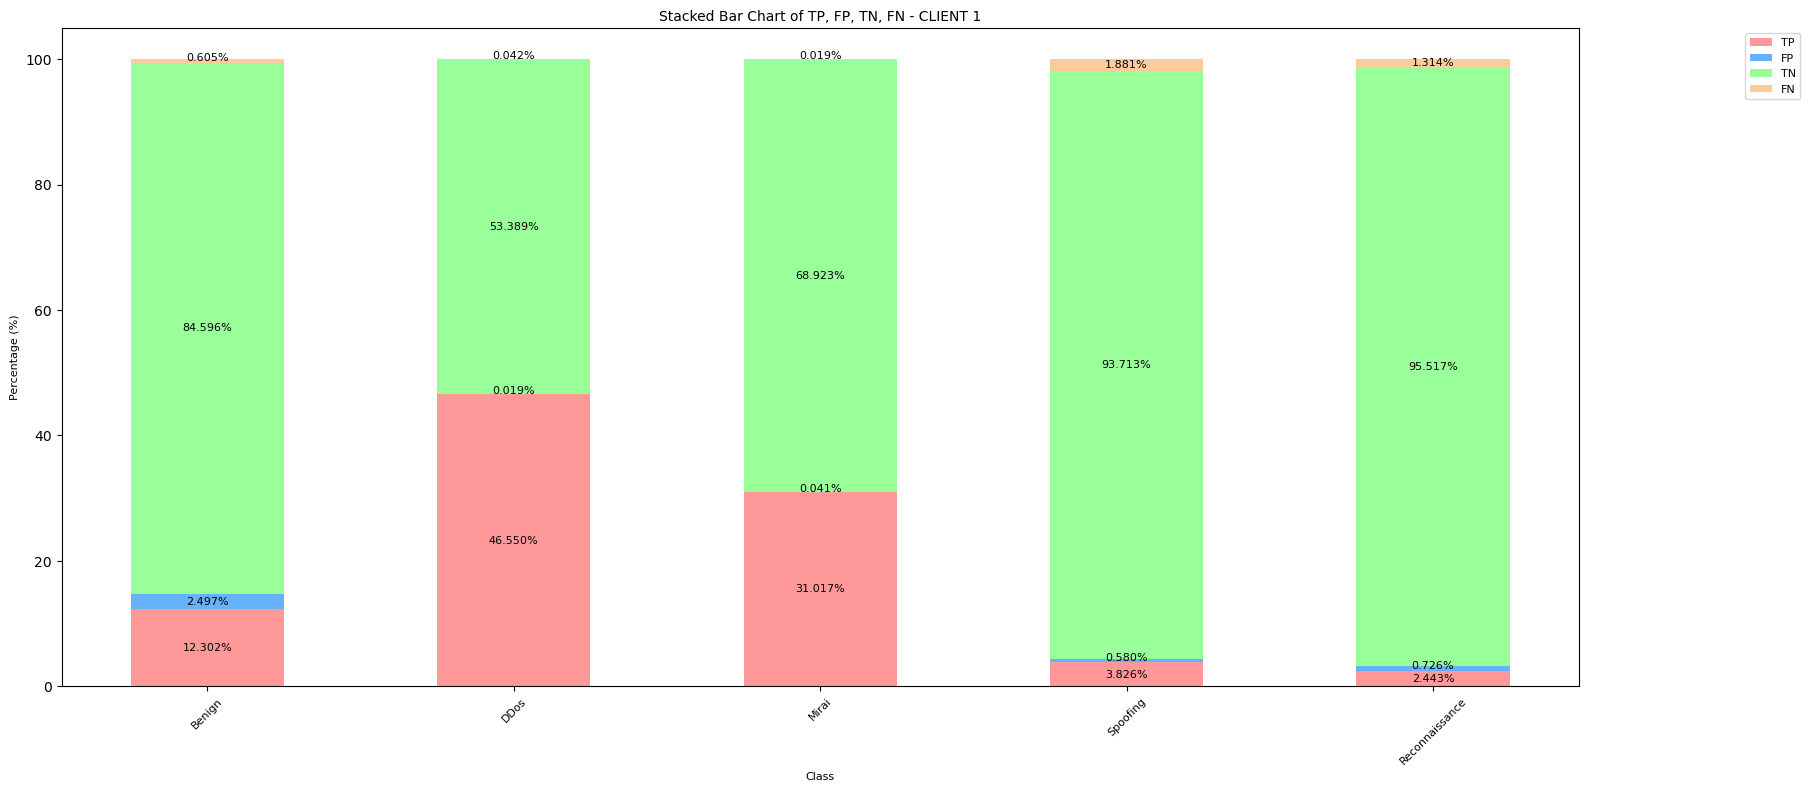

413877
<Sequential name=sequential_2, built=True>
12920/12934 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 14:22:18.268638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 14:22:18.457388: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 14:22:18.500251: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 14:22:18.636782: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 272 bytes spill stores, 272 bytes spill loads



12934/12934 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Sequential name=sequential_2, built=True>
12934/12934 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
<Sequential name=sequential_2, built=True>
12934/12934 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12934/12934 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
<Sequential name=sequential_2, built=True>
12934/12934 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Precision Score Client 2:  [0.5681877678904959, 0.8963306084984815, 0.9023010782350115, 0.9013505025255819, 0.9052421422182872]
Recall Score Client 2:  [0.4615986153632389, 0.8391816666784099, 0.8456503010211318, 0.8499634121956431, 0.8497870543354116]
F1 Score Client 2:  [0.45597725864885935, 0.8592552453101856, 0.8662102192224379, 0.8691929557578183, 0.8702524057678639]


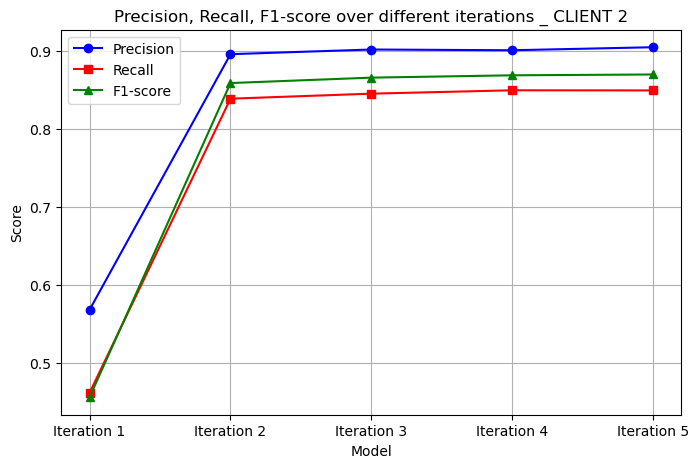

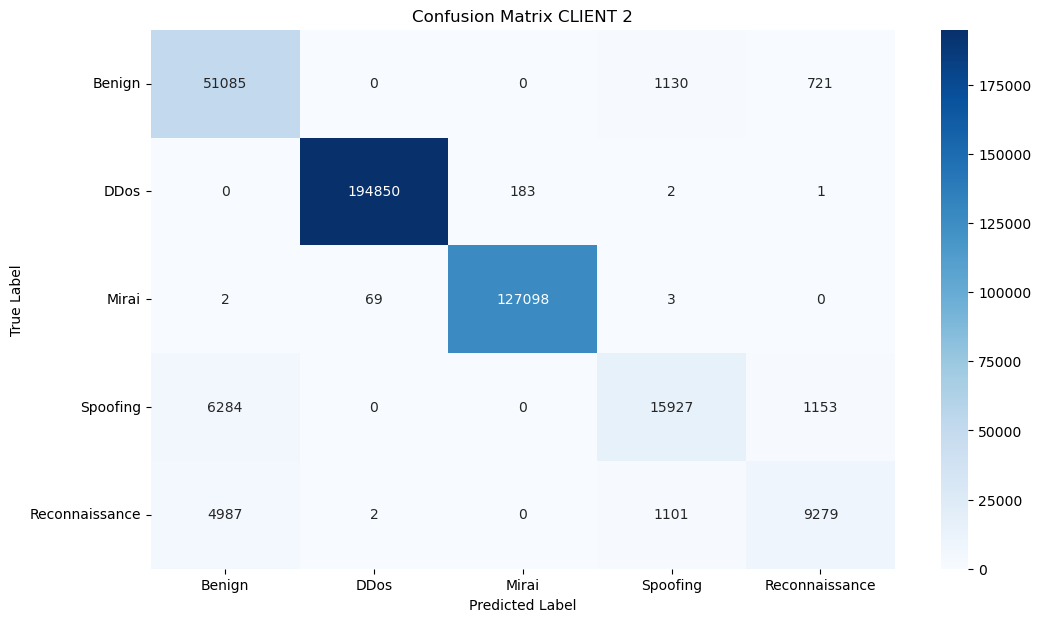

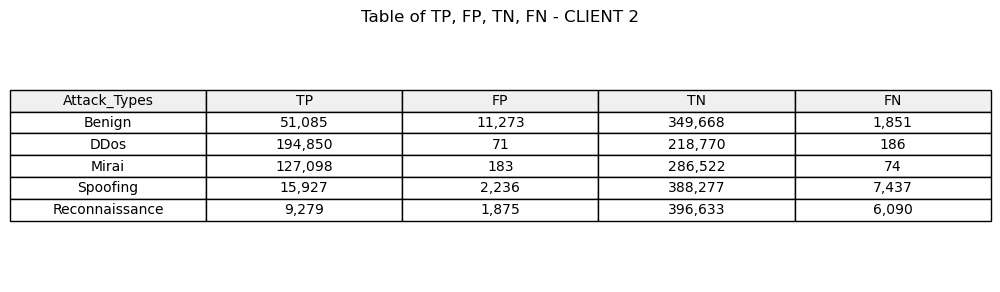

/tmp/ipykernel_69410/3927783715.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)


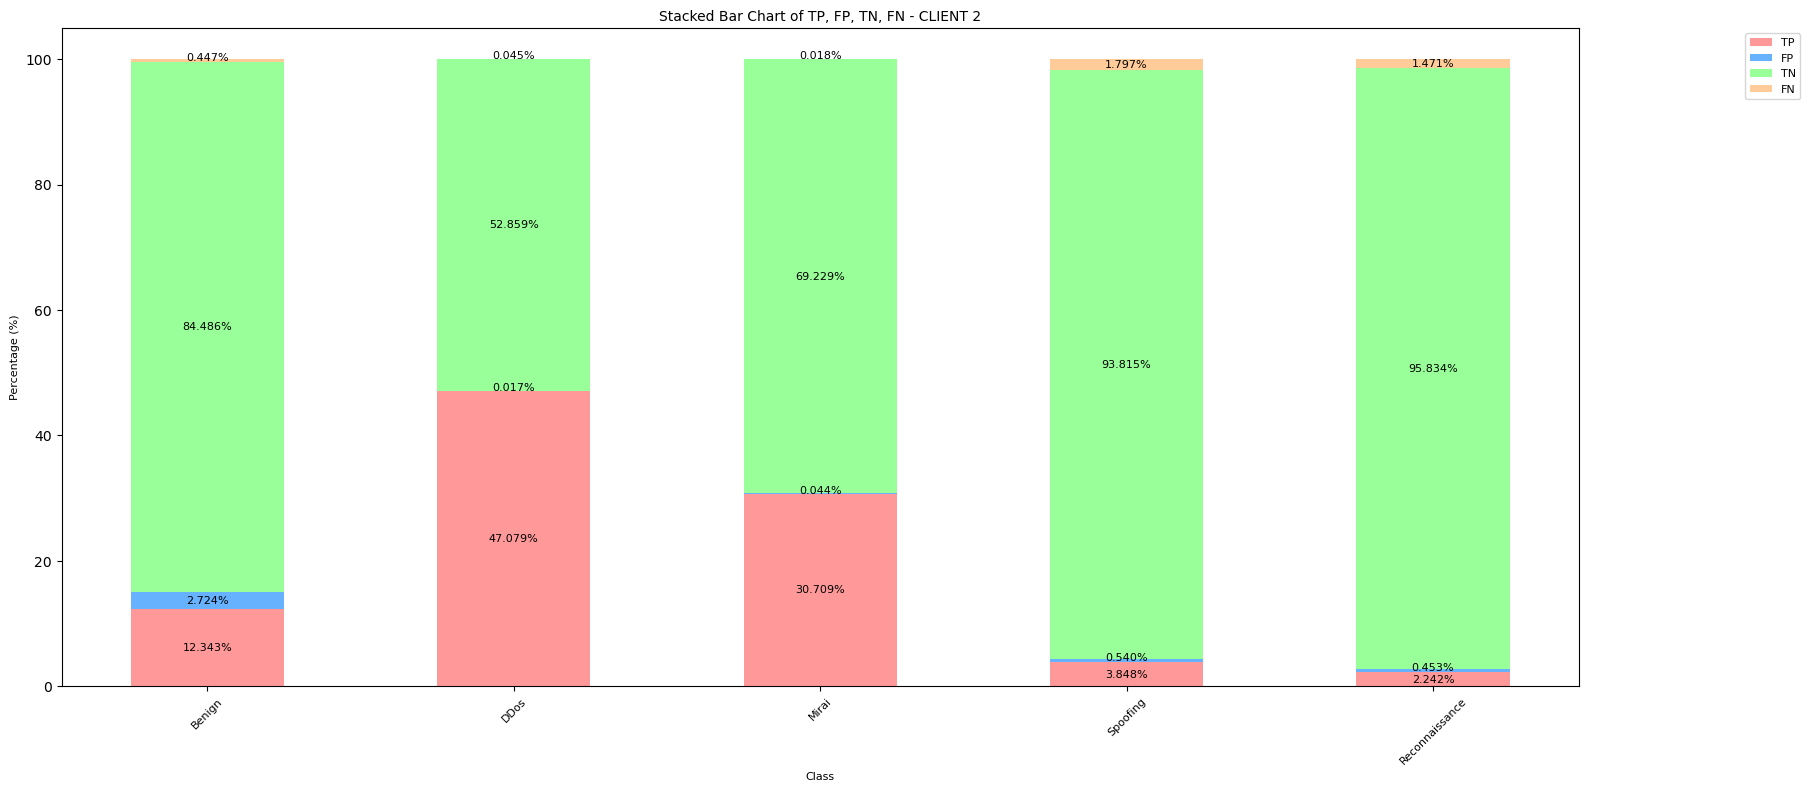

In [7]:
# Lặp cho Client 1 và Client 2
for client_idx in [1, 2]:
    precisions = []
    recalls = []
    f1s = []

    X_test = []
    y_test = []
    for X_batch, y_batch in test_gens[client_idx].take(stepsTest_Clients[client_idx]):
        X_test.append(X_batch.numpy())
        y_test.append(y_batch.numpy())
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    print(len(X_test))
    for iteration in range(actual_iterations[f'client_{client_idx}']):
        print(models[f'client_{client_idx}'][iteration])
        y_pred_pre = models[f'client_{client_idx}'][iteration].predict(X_test, verbose=1)
        y_pred = np.argmax(y_pred_pre, axis=1)
        
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
    print(f"Precision Score Client {client_idx}: ", precisions)
    print(f"Recall Score Client {client_idx}: ", recalls)
    print(f"F1 Score Client {client_idx}: ", f1s)

    # Vẽ biểu đồ Precision, Recall, F1-score
    plt.figure(figsize=(8, 5))
    plt.plot(Iterations[f'client_{client_idx}'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
    plt.plot(Iterations[f'client_{client_idx}'], recalls, marker='s', linestyle='-', label="Recall", color='red')
    plt.plot(Iterations[f'client_{client_idx}'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, F1-score over different iterations _ CLIENT {client_idx}")
    plt.legend()
    plt.grid(True)
    plt.savefig(tempdirs[client_idx] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix CLIENT {client_idx}")
    plt.savefig(tempdirs[client_idx] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

    metrics = []
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])

    df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title(f"Table of TP, FP, TN, FN - CLIENT {client_idx}", fontsize=12, pad=5)
    plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()

    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100

    fig, ax = plt.subplots(figsize=(18, 8))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]

    ax.set_xlabel("Class", fontsize=8)
    ax.set_ylabel("Percentage (%)", fontsize=8)
    ax.set_title(f"Stacked Bar Chart of TP, FP, TN, FN - CLIENT {client_idx}", fontsize=10, pad=5)
    ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
    ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))
    plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()


Log files: {'client_0': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv'], 'client_1': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv'], 'client_2': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv']}


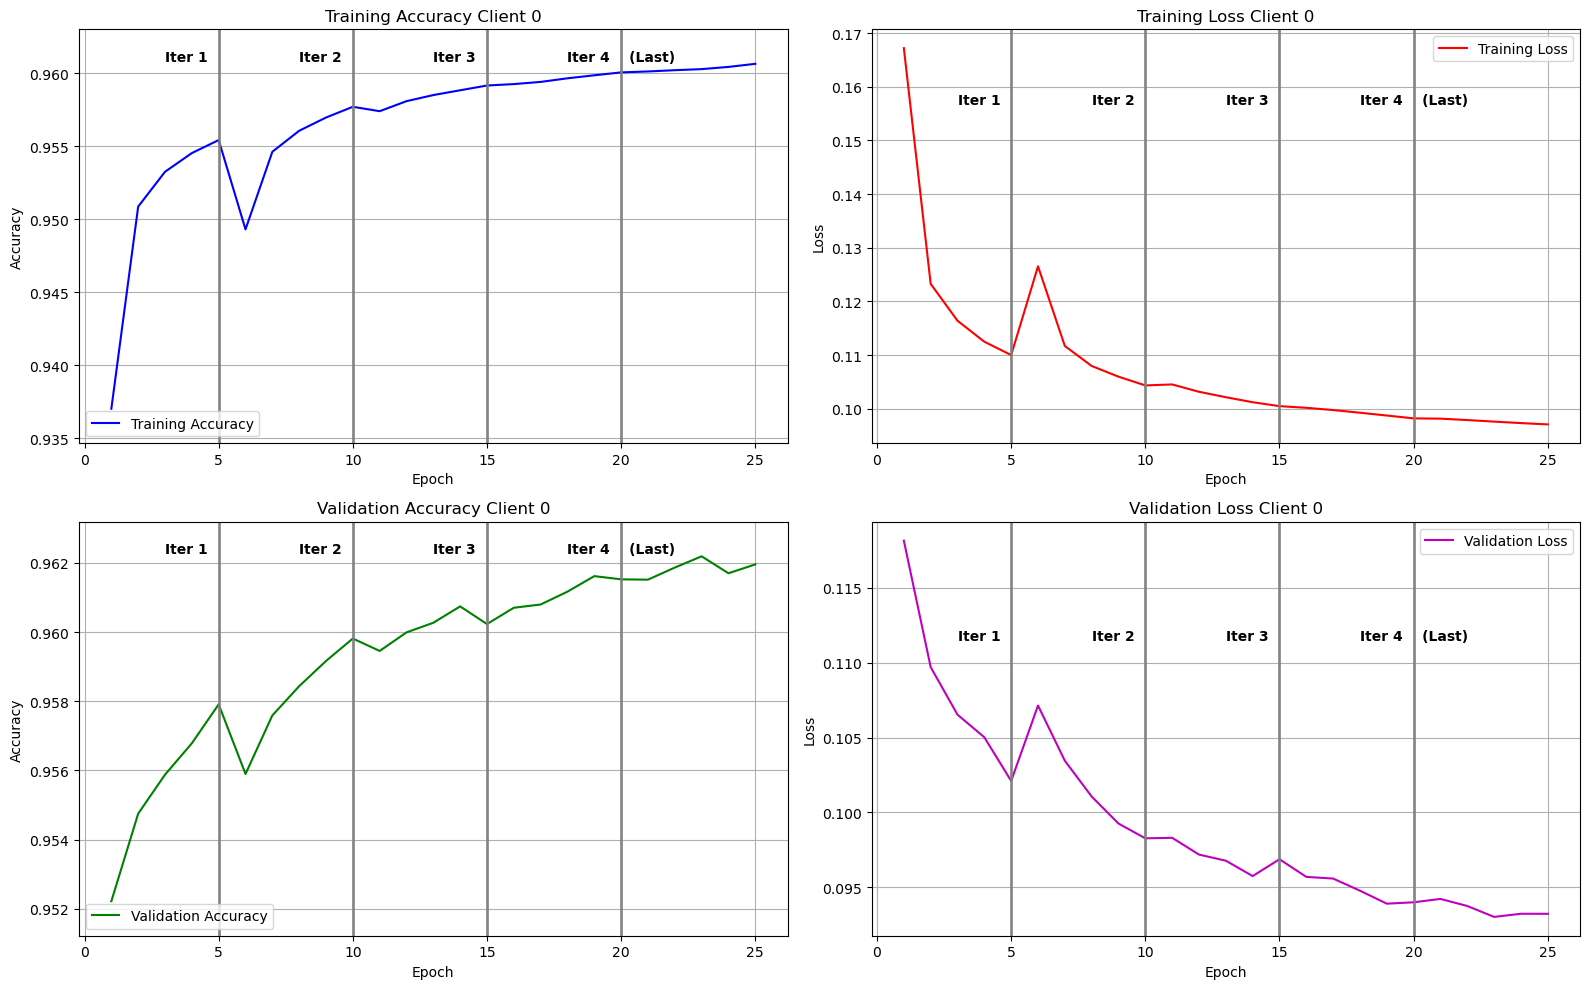

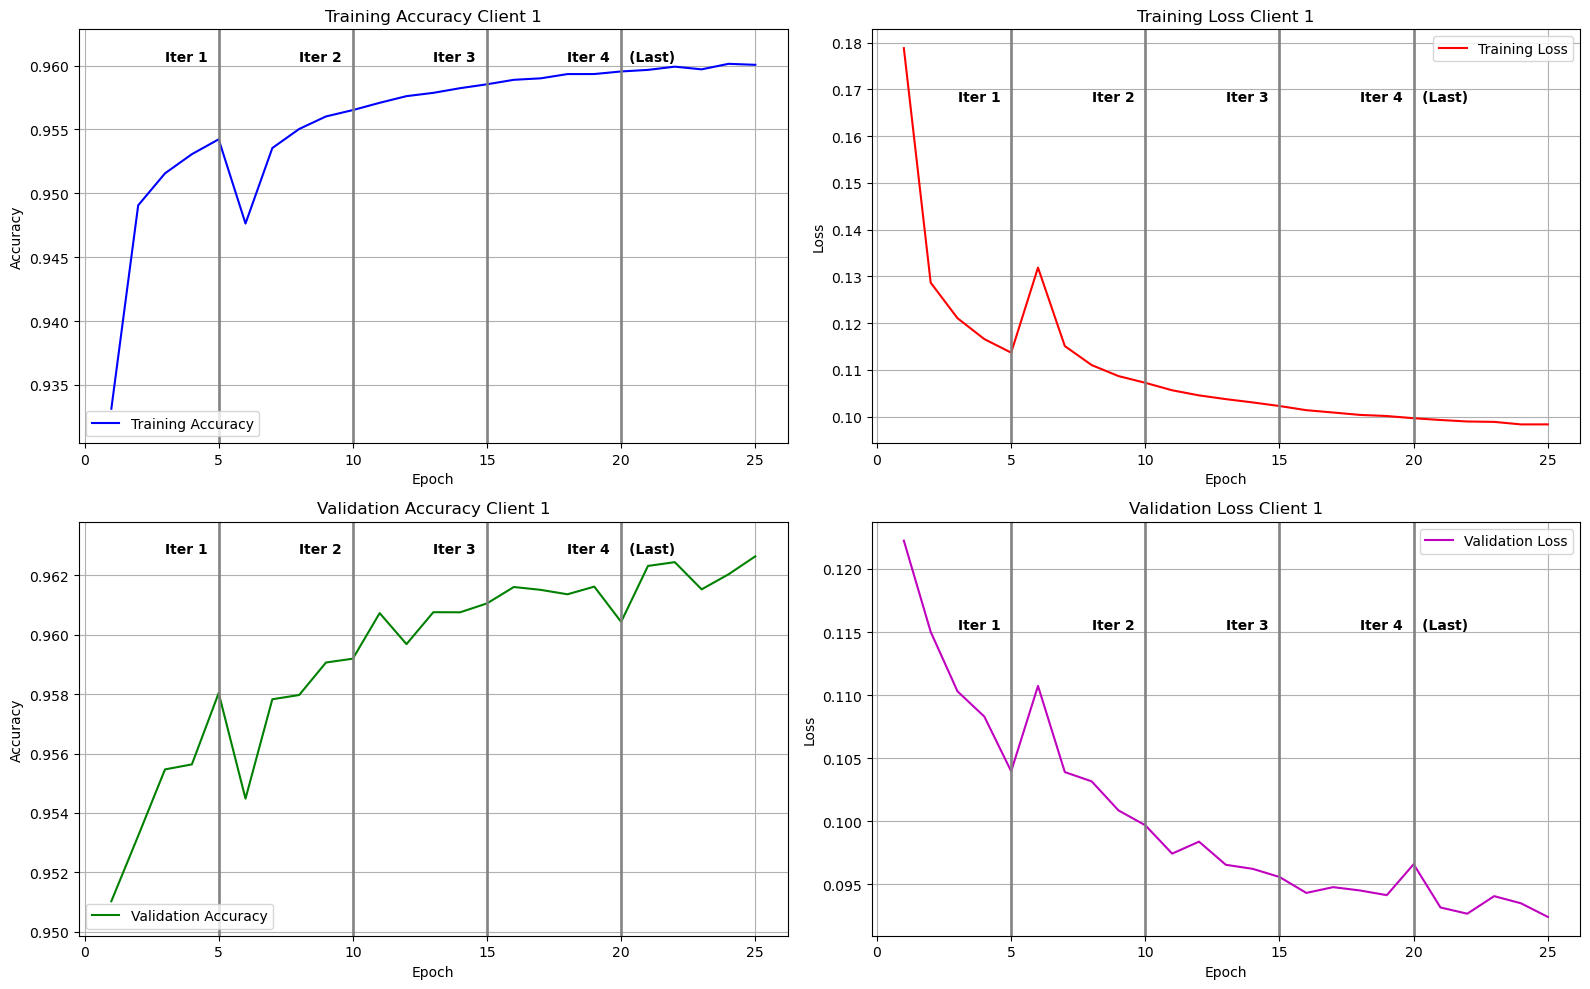

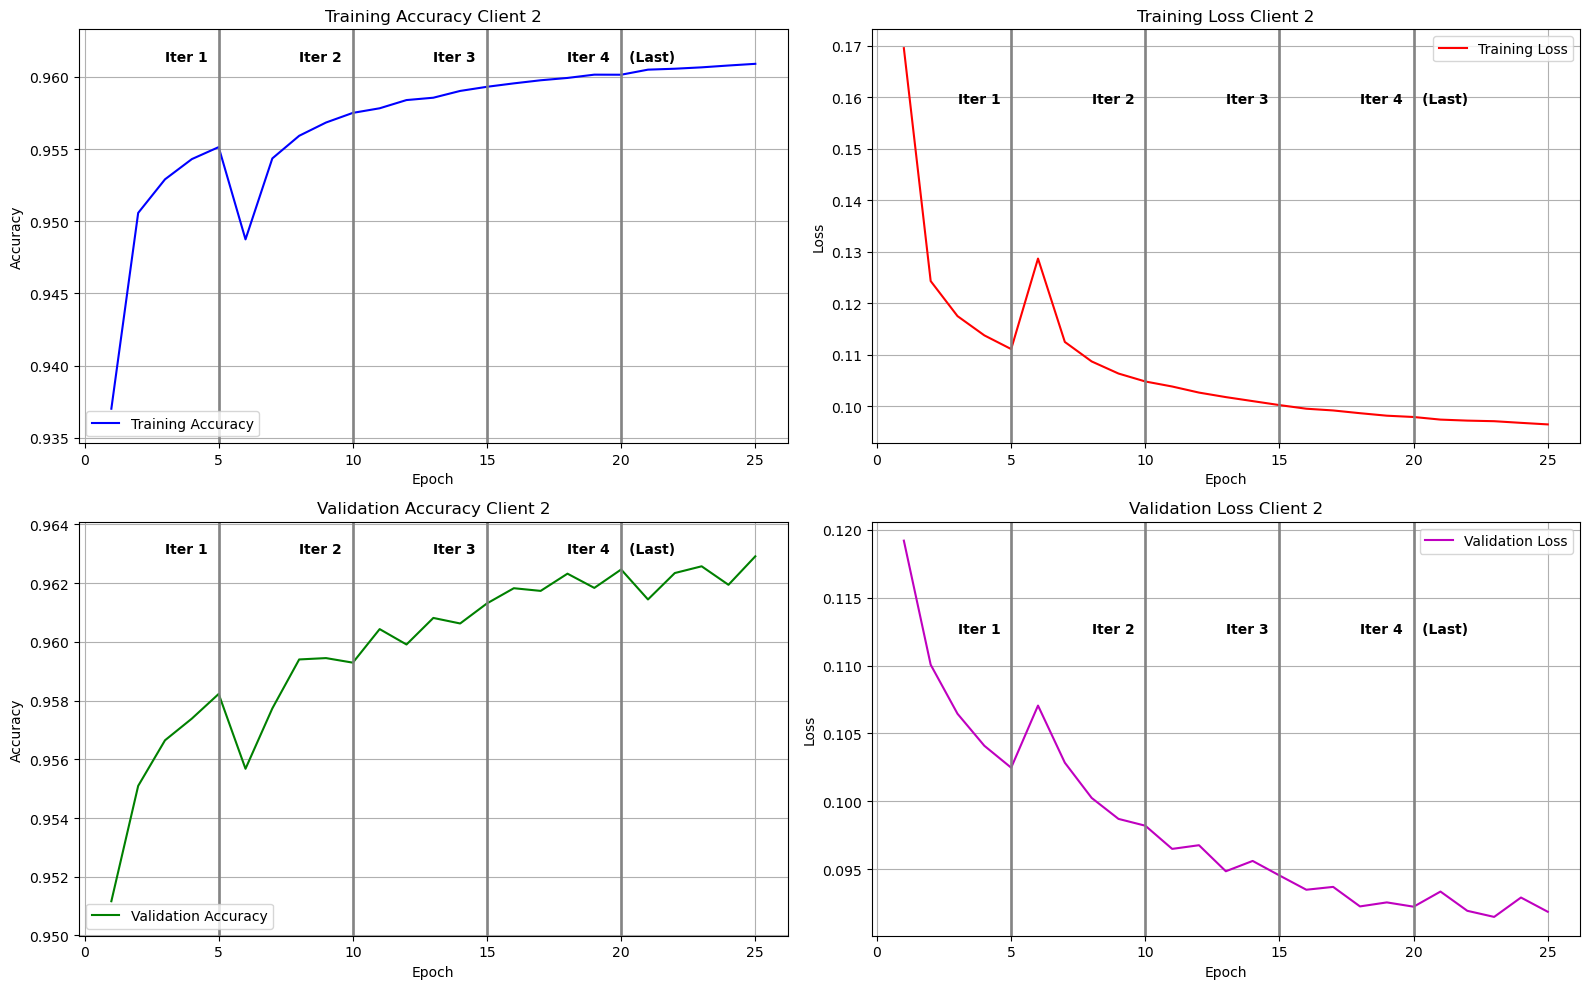

In [15]:
# Phần vẽ biểu đồ log (đã điều chỉnh để giữ tính trực quan)
log_names = {f'client_{i}': [f"Iteration_{j+1}.csv" for j in range(actual_iterations[f'client_{i}'])] for i in range(len(active_clients_list))}
print(f"Log files: {log_names}")

for i in range(len(active_clients_list)):
    all_logs = []
    for log_name in log_names[f'client_{i}']:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    if not all_logs:
        print(f"No log files found for client_{i}, skipping log plots.")
        continue

    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)

    plt.figure(figsize=(16, 10))

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_acc = max(log_df['accuracy']) if not log_df['accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_acc  # Đặt nhãn ngay trên đỉnh giá trị tối đa
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(iter_idx * 5 - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_val_acc = max(log_df['val_accuracy']) if not log_df['val_accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_val_acc  # Đặt nhãn ngay trên đỉnh giá trị tối đa
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(iter_idx * 5 - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Training Loss (giữ nguyên logic cũ)
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Loss (giữ nguyên logic cũ)
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/train_valid_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

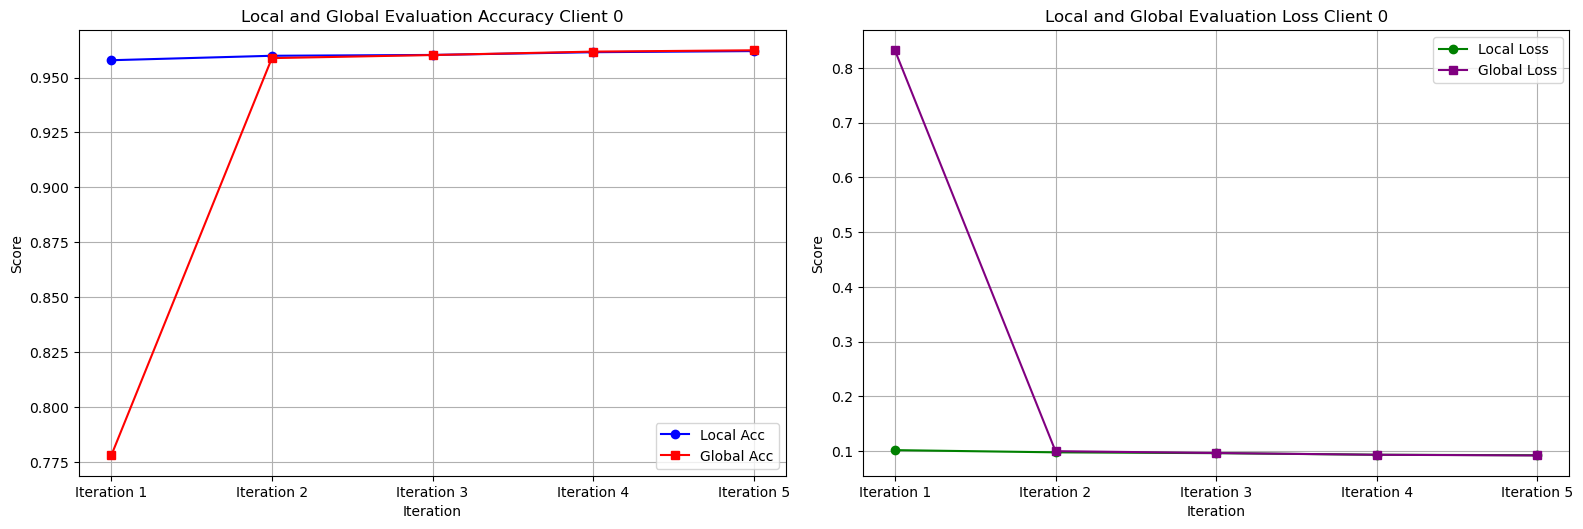

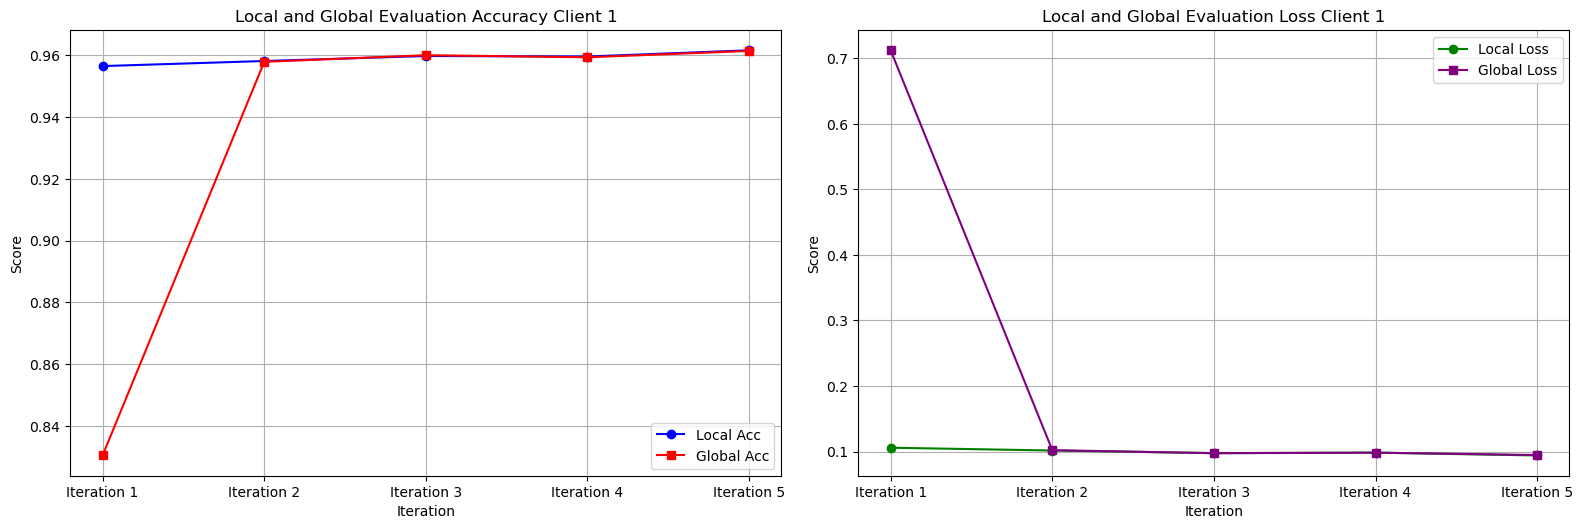

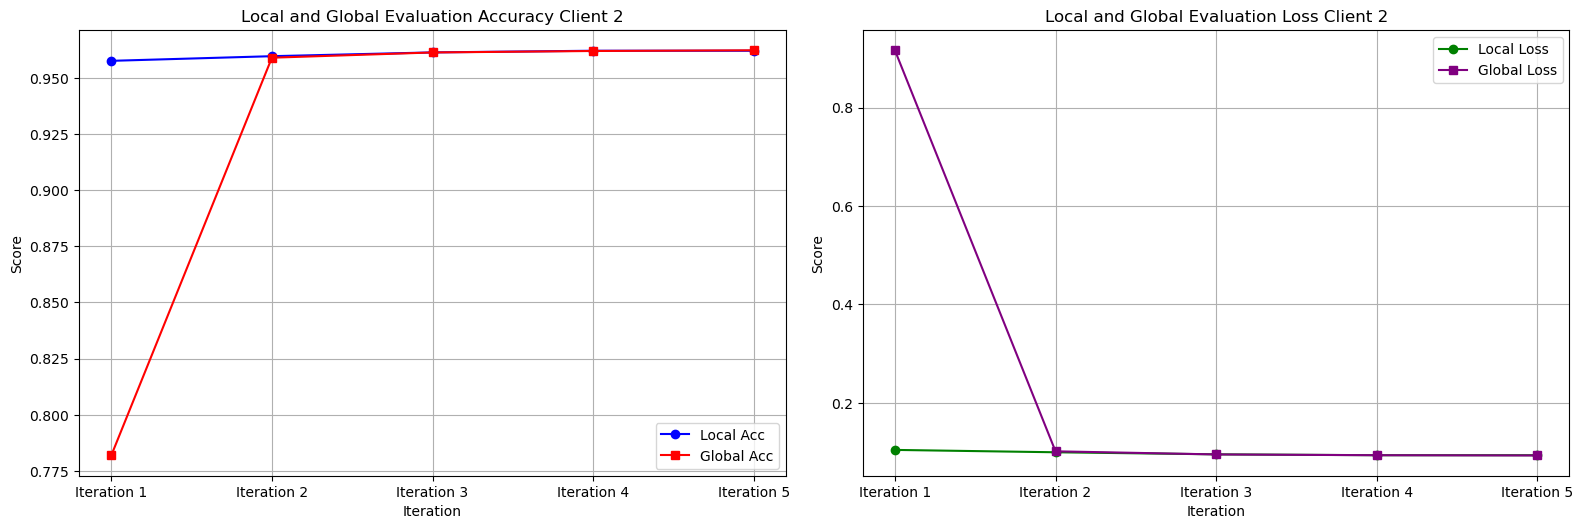

In [9]:
# Phần vẽ local/global evaluation
for i in range(len(active_clients_list)):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations[f'client_{i}'], local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations[f'client_{i}'], global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations[f'client_{i}'], local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations[f'client_{i}'], global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/evaluation_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

#Client 2

precisions = []
recalls = []
f1s = []

#Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.savefig(tempdirs[2]+ "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.savefig(tempdirs[2]+ "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ bảng
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 2", fontsize=12, pad=5)

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

## Chuẩn hóa dữ liệu (tính tỷ lệ phần trăm)
df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

# Vẽ biểu đồ cột chồng với sửa lỗi vị trí nhãn
fig, ax = plt.subplots(figsize=(18, 8))  # Tăng kích thước để có không gian hơn
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            # Đặt nhãn ở giữa phần hiện tại dựa trên bottom và height
            y_pos = bottom[i] + height / 2  # Căn giữa nhãn trong phần hiện tại
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,  # Chữ nằm ngang
                    fontsize=8, color="black")
    bottom += df_metrics[metric]  # Cập nhật bottom cho phần tiếp theo

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 2", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()